In [1]:
import numpy as np
import matplotlib.pyplot as  plt
import numpy

#Exercises

# Changing Micograd

In [2]:
class Tensor:
   #  Tensor objects   take precedence in mixed-type operations
  __array_priority__ = 100

  def __init__(self, x : np.ndarray,children=()):
    self.data = np.array(x,dtype=float) if  not isinstance(x,np.ndarray) else  x
    self.grad = np.zeros_like(self.data,dtype=float)
    self._prev = set(children)
    self._backward =  lambda :None

  def __repr__(self) -> str:
    #np array  use  space when converted to   string
    d_str = np.array2string(self.data,separator=',')
    g_str = np.array2string(self.grad,separator=',')
    return f'Tensor(data = {d_str},\n grad = {g_str})'

  @property
  def shape(self):
    return self.data.shape

  @property
  def ndim(self):
    return  self.data.ndim


  def __matmul__(self,other):
    other_tensor = other if isinstance(other,Tensor) else Tensor(other)

    assert other_tensor.shape[0] == self.data.shape[1],\
        f'shape mismatch self.data.shape={self.data.shape} x other_tensor.shape={other_tensor.shape}'

    if other_tensor.ndim ==0 or self.ndim==0:
      return  self *  other_tensor

    out =  Tensor(self.data @ other_tensor.data,(self,other_tensor))

    # x@w ,w is  the  other
    def _backward():
      #dl/dy * W.T(other)
      self.grad += out.grad @ other_tensor.data.T
      #X.T(self)* d/dy
      other_tensor.grad += self.data.T @ out.grad
    out._backward = _backward
    return  out

  def relu(self):
      # If data < 0, output is 0. Otherwise, pass it through.
      out = Tensor(np.maximum(0,self.data),(self,))

      def _backward():
          # If  negative (and reset to 0), no gradient passes through.
          # If it was positive, the gradient passes through unchanged .
          self.grad += (out.data > 0) * out.grad

      out._backward = _backward
      return out

  def tanh(self):
      # with numpy
      out = Tensor(np.tanh(self.data),(self,))

      def _backward():
          # Derivative of tanh is (1 - np.pow(tanh(x),2))
          self.grad += (1 - np.pow(out.data,2)) * out.grad

      out._backward = _backward
      return out


  def __neg__(self):
      # Allows you to type "-a"
      return self * -1

  def __sub__(self, other):
      # Allows you to type "a - b" (it becomes a + (-b))
      return self + (-other)

  def __rsub__(self,other):
      #Allows you to  type  b - a
      return other + (-self)

  def __radd__(self, other):
      # Allows you to type "2 + a"
      return self + other

  def __mul__(self, other):
    other = other if isinstance(other, Tensor) else Tensor(other)
    out = Tensor(self.data * other.data, (self, other))

    def _backward():
        # dL/dself = other.data * out.grad
        grad_self = other.data * out.grad
        # dL/dother = self.data * out.grad
        grad_other = self.data * out.grad

        # SELF (Broadcasting)
        if self.ndim < out.grad.ndim:
            drop_dims = tuple(range(out.grad.ndim - self.ndim))
            self.grad += grad_self.sum(axis=drop_dims)
        elif self.ndim == 0:
            self.grad += grad_self.sum()
        elif self.shape != out.grad.shape:
            axes = [i for i, (d1, d2) in enumerate(zip(self.shape, out.grad.shape)) if d1==1 and d2>1]
            self.grad += grad_self.sum(axis=tuple(axes), keepdims=True) if axes else grad_self
        else:
            self.grad += grad_self

        #  OTHER (Broadcasting)
        if other.ndim < out.grad.ndim:
            drop_dims = tuple(range(out.grad.ndim - other.ndim))
            other.grad += grad_other.sum(axis=drop_dims)
        elif other.ndim == 0:
            other.grad += grad_other.sum()
        elif other.shape != out.grad.shape:
            axes = [i for i, (d1, d2) in enumerate(zip(other.shape, out.grad.shape)) if d1==1 and d2>1]
            other.grad += grad_other.sum(axis=tuple(axes), keepdims=True) if axes else grad_other
        else:
            other.grad += grad_other

    out._backward = _backward
    return out


  def __rmatmul__(self, other):
      other_tensor = other if isinstance(other, Tensor) else Tensor(other)
      return other_tensor @ self

  def __truediv__(self, other):
      # Allows "a / b" (it becomes a * b^-1)
      return self * other**-1

  def __pow__(self, other):
      assert isinstance(other, (int, float)), "Exponent must be a scalar (int or float)"
      out = Tensor(self.data**other, (self,))

      def _backward():
          # Derivative of x^n is n * x^(n-1)
          self.grad += (other * (self.data**(other-1))) * out.grad
      out._backward = _backward
      return out

  def exp(self):
    out = Tensor(np.exp(self.data),(self,))
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  # The Engine (Backpropagation)

  def backward(self):
      topo = []
      visited = set()
      def build_topo(v):
          if v not in visited:
              visited.add(v)
              for child in v._prev:
                  build_topo(child)
              topo.append(v)
      build_topo(self)

      self.grad = np.ones_like(self.data,dtype=float)
      for node in reversed(topo):
          node._backward()

  def log(self):
      out = Tensor(np.log(self.data),(self,))
      def _backward():
          # Derivative of log(x) is 1/x
          self.grad += (1.0 / self.data) * out.grad
      out._backward = _backward
      return out

  def sum(self, axis=None, keepdims=False):
      out = Tensor(np.sum(self.data, axis=axis, keepdims=keepdims), (self,))

      def _backward():
          grad_output = out.grad
          if axis is not None and not keepdims:
              if isinstance(axis, int):
                  grad_output = np.expand_dims(grad_output, axis)
              else:
                  for ax in sorted(axis):
                      grad_output = np.expand_dims(grad_output, ax)
          #copy grads  to input that contributd to sum
          self.grad += grad_output * np.ones_like(self.data)

      out._backward = _backward
      return out

  def max(self, axis=None, keepdims=False):
    out = Tensor(np.max(self.data, axis=axis, keepdims=keepdims), (self,))

    def _backward():
        grad_output = out.grad
        if axis is not None and not keepdims:
            if isinstance(axis, int):
                grad_output = np.expand_dims(grad_output, axis)
            else:
                for ax in sorted(axis):
                    grad_output = np.expand_dims(grad_output, ax)

        #  a mask: 1 where data == max, 0 elsewhere
        mask = (self.data == out.data)
        #copy grads  to max elements
        self.grad += mask * grad_output

    out._backward = _backward
    return out


  def __add__(self, other):
    other = other if isinstance(other, Tensor) else Tensor(other)
    out = Tensor(self.data + other.data, (self, other))

    def _backward():
      # If out.grad is (32, 10) and self is (10,),  sum axis 0
      if self.ndim < out.grad.ndim: # if  self is 1D, out is 2D
          drop_dims = tuple(range(out.grad.ndim - self.ndim))
          self.grad += out.grad.sum(axis=drop_dims)
      elif self.ndim == 0: # self is scalar
          self.grad += out.grad.sum()
      elif self.shape != out.grad.shape: # Same ndim, but dim=1 somewhere
            axes = [i for i, (d1, d2) in enumerate(zip(self.shape, out.grad.shape)) if d1==1 and d2>1]
            if axes:
                self.grad += out.grad.sum(axis=tuple(axes), keepdims=True)
            else:
                self.grad += out.grad
      else:
          self.grad += out.grad


      if other.ndim < out.grad.ndim:
          drop_dims = tuple(range(out.grad.ndim - other.ndim))
          other.grad += out.grad.sum(axis=drop_dims)
      elif other.ndim == 0:
          other.grad += out.grad.sum()
      elif other.shape != out.grad.shape:
            axes = [i for i, (d1, d2) in enumerate(zip(other.shape, out.grad.shape)) if d1==1 and d2>1]
            if axes:
                other.grad += out.grad.sum(axis=tuple(axes), keepdims=True)
            else:
                other.grad += out.grad
      else:
          other.grad += out.grad

    out._backward = _backward
    return out


In [3]:
x = np.random.normal(loc=1,scale=1,size=(2,4))
x

array([[ 2.02263126,  1.08743259, -0.03474541,  1.63278941],
       [ 0.25149828,  0.87437832,  0.83186988,  0.98393812]])

In [4]:
inp = Tensor(x)
w = np.arange(0,5,.7).reshape(4,2)
b = 1

In [5]:
w =  w.reshape(4,2)
w.shape

(4, 2)

In [6]:
y = w @ inp  + b
y

Tensor(data = [[ 1.1760488 , 1.61206482, 1.58230892, 1.68875668],
 [ 4.35983015, 4.3586001 , 2.69828319, 5.35217522],
 [ 7.54361151, 7.10513537, 3.81425745, 9.01559376],
 [10.72739286, 9.85167065, 4.93023172,12.6790123 ]],
 grad = [[0.,0.,0.,0.],
 [0.,0.,0.,0.],
 [0.,0.,0.,0.],
 [0.,0.,0.,0.]])

In [9]:
y,y.backward(),inp

(Tensor(data = [[ 1.1760488 , 1.61206482, 1.58230892, 1.68875668],
  [ 4.35983015, 4.3586001 , 2.69828319, 5.35217522],
  [ 7.54361151, 7.10513537, 3.81425745, 9.01559376],
  [10.72739286, 9.85167065, 4.93023172,12.6790123 ]],
  grad = [[1.,1.,1.,1.],
  [1.,1.,1.,1.],
  [1.,1.,1.,1.],
  [1.,1.,1.,1.]]),
 None,
 Tensor(data = [[ 2.02263126, 1.08743259,-0.03474541, 1.63278941],
  [ 0.25149828, 0.87437832, 0.83186988, 0.98393812]],
  grad = [[50.4,50.4,50.4,50.4],
  [67.2,67.2,67.2,67.2]]))

In [10]:
y.tanh()

Tensor(data = [[0.82620162,0.92346458,0.91896171,0.93398867],
 [0.99967337,0.99967256,0.99097666,0.99995511],
 [0.99999944,0.99999865,0.99902771,0.99999997],
 [1.        ,0.99999999,0.99989561,1.        ]],
 grad = [[0.,0.,0.,0.],
 [0.,0.,0.,0.],
 [0.,0.,0.,0.],
 [0.,0.,0.,0.]])

#Training  with  sklearn MLP and also custom train  with Tensorclass on same data

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

In [12]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')
X = X.astype('float32') / 255.0

# The target 'y' is a string categorical, convert to integer
y = y.astype('int')

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
X_train.iloc[0]

,47339
pixel1,0.0
pixel2,0.0
pixel3,0.0
pixel4,0.0
pixel5,0.0
...,...
pixel780,0.0
pixel781,0.0
pixel782,0.0
pixel783,0.0


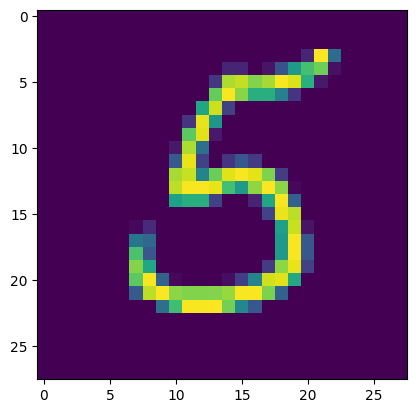

In [14]:
plt.imshow(np.array(X_train.iloc[0]).reshape(28,28))

In [15]:
#train with MLP classifier
clf = MLPClassifier(random_state=1, max_iter=10).fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


In [16]:
clf.score(X_test,y_test) #accuracy

0.9722142857142857

In [17]:
#use  5000 samples for my custom tensor
X_train,y_train = np.array(X_train.iloc[:5000]),np.array(y_train.iloc[:5000])

In [18]:
X_train.shape,X_train[0].shape

((5000, 784), (784,))

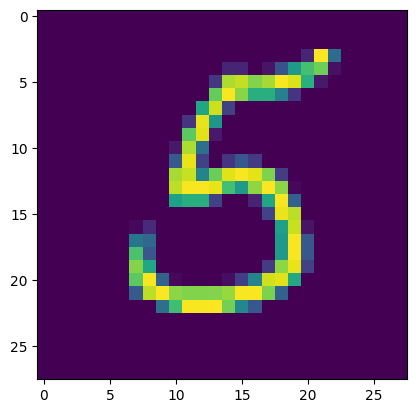

In [19]:
plt.imshow(X_train[0].reshape(28,28))

In [20]:
x  = X_train[0]
x.shape

(784,)

In [21]:
#checking the model
dims =[784,392,196,10]
ws  =  [Tensor(np.random.randn(dims[i],dims[i+1])) for i in range(len(dims)-1)]
b = [Tensor(np.zeros(dims[i])) for i in range(1,len(dims)) ]
for t,bi in zip(ws,b):
  print(f'w {t.data.shape} and bias {bi.data.shape}') #checkng the shapes

w (784, 392) and bias (392,)
w (392, 196) and bias (196,)
w (196, 10) and bias (10,)


In [56]:
class Module:

    def zero_grad(self):
        v = ['Weights','Biases']
        for p in self.parameters()[v[0]]:
            p.grad = np.zeros_like(p.grad)
        for p in self.parameters()[v[1]]:
            p.grad = np.zeros_like(p.grad)
    def parameters(self):
        return {}

class model(Module):
  def __init__(self):
    self.dims = [784, 392, 196, 10]
    self.weights = [Tensor(np.random.randn(self.dims[i], self.dims[i+1]) * 0.01) for i in range(len(self.dims)-1)]
    self.biases = [Tensor(np.zeros(self.dims[i])) for i in range(1, len(self.dims))]

  def parameters(self):
    return {
        'Weights':self.weights,
         'Biases':self.biases
        }

  def __call__(self,inp_tensor):
    h1 = (inp_tensor @ self.weights[0] + self.biases[0]).relu()
    h2 = (h1 @ self.weights[1] + self.biases[1]).relu()
    h3 = h2 @ self.weights[2] + self.biases[2]
    #return logits
    return h3

In [57]:
train_model = model()

In [58]:
def loss_fn(batch_size, X, y):
  #  Data (Batch of images)
  # indexes of x_data
  idxs = np.random.permutation(len(X))[:batch_size]
  Xb = X[idxs]
  yb = y[idxs]

  #  Tensor for the batch input
  inputs_tensor = Tensor(Xb)

  # 2. Forward Pass (The Matrix Ops)
  logits = train_model(inputs_tensor)

  #  loss(softmax -> log loss)
  shifted = logits - logits.max(axis=-1,keepdims=True)
  exp = shifted.exp()
  exp_sum = exp.sum(axis=-1,keepdims=True)
  probs =  exp/exp_sum

  # Multi-Class
  y_onehot = np.zeros_like(probs.data)
  y_onehot[np.arange(batch_size), yb] = 1.0
  target_mask = Tensor(y_onehot)

  #Final Multi-Class Loss
  loss = -(probs.log() * target_mask).sum() / batch_size
  #accuracy
  pred =  np.argmax(probs.data,axis=1)
  accuracy = accuracy_score(yb,pred)
  return loss,accuracy

In [62]:
#training
for k in range(100):
    #forward
    loss, accuracy = loss_fn(32,X_train,y_train)

    #reset grads
    train_model.zero_grad()
    loss.backward() #backprop

    #sGD
    lr = 0.5
    for w,b in zip(train_model.parameters()['Weights'],train_model.parameters()['Biases']):
        w.data -= lr * w.grad
        b.data -= lr * b.grad
    if k % 1 == 0:
        print(f'Step {k} | Loss {loss.data:.4f} | Acc {accuracy:.4f}')

Step 0 | Loss 2.2725 | Acc 0.1250
Step 1 | Loss 2.3050 | Acc 0.0938
Step 2 | Loss 2.2521 | Acc 0.2812
Step 3 | Loss 2.2674 | Acc 0.0938
Step 4 | Loss 2.2722 | Acc 0.1875
Step 5 | Loss 2.2676 | Acc 0.0938
Step 6 | Loss 2.2383 | Acc 0.2500
Step 7 | Loss 2.2156 | Acc 0.2500
Step 8 | Loss 2.2466 | Acc 0.1875
Step 9 | Loss 2.2524 | Acc 0.2812
Step 10 | Loss 2.1986 | Acc 0.0625
Step 11 | Loss 2.1576 | Acc 0.2500
Step 12 | Loss 2.1190 | Acc 0.1875
Step 13 | Loss 2.1146 | Acc 0.2188
Step 14 | Loss 2.0442 | Acc 0.2500
Step 15 | Loss 1.9170 | Acc 0.3438
Step 16 | Loss 2.0920 | Acc 0.3438
Step 17 | Loss 2.2023 | Acc 0.2188
Step 18 | Loss 2.0874 | Acc 0.3750
Step 19 | Loss 1.8622 | Acc 0.5938
Step 20 | Loss 1.9327 | Acc 0.3438
Step 21 | Loss 1.9080 | Acc 0.3125
Step 22 | Loss 1.6989 | Acc 0.4688
Step 23 | Loss 1.3816 | Acc 0.6250
Step 24 | Loss 2.9374 | Acc 0.2188
Step 25 | Loss 3.4478 | Acc 0.2500
Step 26 | Loss 3.1032 | Acc 0.0938
Step 27 | Loss 2.2823 | Acc 0.1562
Step 28 | Loss 2.2402 | Acc 0.

In [63]:
train_model.parameters()

{'Weights': [Tensor(data = [[ 0.01589263,-0.01047918, 0.00042397,...,-0.00374368,-0.01417061,
     0.00341111],
   [-0.01091369,-0.00676979,-0.00374199,..., 0.01573662, 0.00415769,
     0.00805362],
   [ 0.00089787,-0.01825583, 0.01177766,..., 0.01631287, 0.01069916,
    -0.01117684],
   ...,
   [ 0.01773782,-0.02000249,-0.00915947,...,-0.01022105, 0.00932533,
     0.01289342],
   [ 0.00268263, 0.00463496,-0.00758395,..., 0.00193342, 0.01969043,
     0.00532149],
   [-0.00172816,-0.00723928,-0.01769   ,..., 0.01225594,-0.01707427,
    -0.0107693 ]],
   grad = [[0.,0.,0.,...,0.,0.,0.],
   [0.,0.,0.,...,0.,0.,0.],
   [0.,0.,0.,...,0.,0.,0.],
   ...,
   [0.,0.,0.,...,0.,0.,0.],
   [0.,0.,0.,...,0.,0.,0.],
   [0.,0.,0.,...,0.,0.,0.]]),
  Tensor(data = [[-0.01553917,-0.01042401, 0.00208693,..., 0.01085116,-0.00375855,
    -0.01134806],
   [ 0.01098679, 0.0132342 ,-0.01798247,..., 0.01709447,-0.01078071,
    -0.00488312],
   [-0.00141861, 0.00369469,-0.01882935,...,-0.02109547, 0.00794206,
 

In [97]:
b = np.random.permutation(5000)[:32] #   same thing for y_test to get equivalent data
x = np.array(X_test)
X  = x[b]#its 8
logits = train_model(X)
pred = np.argmax(logits.data,axis=-1)
pred

array([5, 1, 2, 9, 0, 8, 8, 2, 9, 8, 6, 9, 3, 0, 0, 9, 3, 2, 2, 8, 6, 2,
       0, 9, 8, 3, 0, 0, 9, 1, 9, 3])

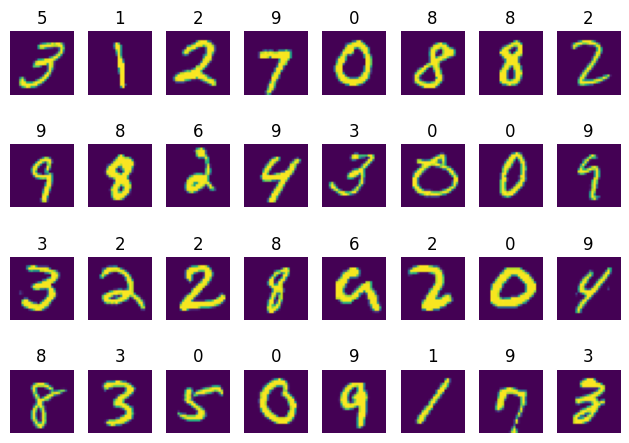

In [98]:
fig,axs = plt.subplots(4,8)
id = 0
for i in range(4):
  for j in  range(8):
    axs[i,j].imshow(X[id].reshape(28,28))
    axs[i,j].set_title(pred[id])
    axs[i,j].axis('off')
    id += 1
plt.tight_layout()
plt.show()   # works for some not all😭👍👍👍✅

In [110]:
true = np.array(y_test)[b]
acc = np.sum(true==pred)/32
acc.item()

0.75